<a href="https://colab.research.google.com/github/kcj4800/Tensorflow_practice/blob/main/inception_model(fine_tuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip -q dogs-vs-cats-redux-kernels-edition.zip -d .
!unzip -q train.zip -d .

100% 813M/814M [00:44<00:00, 19.3MB/s]
100% 814M/814M [00:44<00:00, 19.1MB/s]


In [ ]:
%rm -rf dataset

In [ ]:
import os
import tensorflow as tf
import shutil

os.mkdir('/content/dataset')
os.mkdir('/content/dataset/dog')
os.mkdir('/content/dataset/cat')

for i in os.listdir('/content/train/'):
  if 'cat' in i:
    shutil.copyfile('/content/train/' + i, '/content/dataset/cat/' + i)
  if 'dog' in i:
    shutil.copyfile('/content/train/' + i, '/content/dataset/dog/' + i)


In [ ]:
# validation : 확인, (동) 허가하다.
# split : 쪼개다, 분해하다.
# batch : 한 묶음, 집단
# subset : 부분집합

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/',
    image_size = (150, 150),
    batch_size = 64,
    subset = 'training',
    validation_split = 0.2,
    seed = 1234
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/',
    image_size = (150, 150),
    batch_size = 64,
    subset = 'validation',
    validation_split = 0.2,
    seed = 1234,
)

def 전처리함수(i, 정답) :
  i = tf.cast(i/255.0, tf.float32)
  return i, 정답

'''
# map : 반복가능한 객체 요소를 지정한 함수 실행 후 추출
def conv_abs(x):
    return abs(x)
    
print(list(map(conv_abs,[1,-3,2,0,-5,6])))         # [1, 3, 2, 0, 5, 6]
print(list(map(lambda x:abs(x),[1,-3,2,0,-5,6])))  # [1, 3, 2, 0, 5, 6]

print()

#  filter : 반복가능한 객체 요소를 지정한 함수 조건에 맞는 값 추출 필터함수
# filter(func, iter) : filter함수에 들어가는 func의 참조건에 맞는 데이터만 걸러준다. => 리스트로 형변환하여 사용한다.

def conv_pos(x):
    return abs(x) > 2
    
print(list(filter(conv_pos, [1, -3, 2, 0, -5, 6])))              # [-3, -5, 6]
print(list(filter(lambda x: abs(x) > 2, [1, -3, 2, 0, -5, 6])))  # [-3, -5, 6]
'''

# iterable한 객체들을 함수를 거쳐서 반환해준다.
train_ds = train_ds.map(전처리함수)
val_ds = val_ds.map(전처리함수)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
print(train_ds)
print(val_ds)


<_MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [38]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

# !wget --no-check-certificate \
    # http://storage.googleapis.com/mledu-datasets/inception_v3_weights-tf_dim_ordering_tf_kernels_notop.h5 \ 
    # -O inception_v3.h5

import requests

# google의 inception_v3의 weight값(가중치)를 저장한 값.\
url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
r = requests.get(url, allow_redirects=True)

open('inception_v3.h5', 'wb').write(r.content)

87910968

In [39]:
from tensorflow.python.ops.math_ops import TruncateMod
# 구글의 멋진 Inception_V3 모델 불러오기

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model
from keras.layers.merging.concatenate import concatenate

# 남이 트레이닝 했던 모델을 갖다 쓸때는 input_shape와 output_shape를 주의해야함. 만든사람이 정한 정확한 shape를 알아야한다.
# 원래 InceptionV3는 (299, 299, 3)의 input_shape를 받지만, 텐서플로 케라스에서는 원하는 input_shape값을 지정해줄 수 있다.
# include_top : 탑레이어를 include해서 가져올건지를 결정하는 것. top layer란 마지막 출력 Dense레이어 를 말한다.
# weights = None : weight값을 로드하지 않겠습니다. 현재 weight값을 파일로 가지고 있기 때문.
# 여기서 정한 input_shape과 위에서 정의한 train_ds와 test_ds의 image_size() - input_image_size가 같아야 한다.
inception_model = InceptionV3( input_shape = (150, 150, 3), include_top = False, weights = None )
inception_model.load_weights('inception_v3.h5')

# inception_model.summary()

# plot_model(inception_model, to_file = 'inception_model.png', show_shapes = True, show_layer_names = True)

# 첫 레이어의 Connected to 는 Functional API로 레이어를 만들면 생긴다.
# 맨 마지막에 Dense레이어가 존재 해야 하지만 include_top = False 를 선택했으므로, 가져오지 않는다.
# 이때 마지막 레이어 전까지의 레이어들은 Conv+Pooling으로 이미지를 해체 분석해주고, 이를 이용하여, 마지막 Dense레이어를 이용해서 이를 분류한다.
# 또한, 위의 레이어들은 학습을 시키면 안된다. (weight 업데이트 금지!)

# inception 모델의 레이어들을 하나씩 모두 출력해볼 수 있다.
# inception_model.layers

# 이를 이용해 반복문을 사용하면 하나 하나의 레이어에 똑같은 작업을 시켜줄 수 있다.
for i in inception_model.layers :
  i.trainable = False # 이 레이어에서 학습을 하지 말아주세요. 라는 뜻이다.

# 참고로 가끔 학습을 하기도 한다. 아주 살짝만 미세 조정(학습) fine tuning
# fine tuning 하는 법.
# 예를 들어 Inception 모델을 mixed6을 조금 트레이닝 하고싶다면,

for i in inception_model.layers: # inception_model의 모든 레이어를 불러온다.
  if i.name == 'mixed6':
    i.trainable = True

# 이때 Inception 모델을 mixed6부터 조금 트레이닝 하고싶다면,

unfreeze = False
for i in inception_model.layers:
  if i.name == 'mixed6':
    unfreeze = True
  if unfreeze == True:
    i.trainable = True

# 원하는 레이어만 사용할 수 있다. => Functional API를 이용 - mixed가 한덩어리라는 뜻이므로 보통 이 부분에서 잘라서 쓴다.
# 원하는 레이어만 뽑기
마지막레이어 = inception_model.get_layer('mixed7')



print(마지막레이어) # keras.layers.merging.concatenate.Concatenate => merge : 합병하다, concatenate : 연결된(사슬같이 잇다.)
print(마지막레이어.output)
print(마지막레이어.output_shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
(None, 7, 7, 768)


Epoch 1/5
313/313 [==============================] - 40s 115ms/step - loss: 0.1671 - acc: 0.9526 - val_loss: 0.0988 - val_acc: 0.9596
Epoch 2/5
313/313 [==============================] - 37s 117ms/step - loss: 0.0306 - acc: 0.9891 - val_loss: 0.0859 - val_acc: 0.9700
Epoch 3/5
313/313 [==============================] - 36s 115ms/step - loss: 0.0123 - acc: 0.9962 - val_loss: 0.1104 - val_acc: 0.9694
Epoch 4/5
313/313 [==============================] - 38s 120ms/step - loss: 0.0148 - acc: 0.9947 - val_loss: 0.1384 - val_acc: 0.9666
Epoch 5/5
313/313 [==============================] - 38s 119ms/step - loss: 0.0126 - acc: 0.9952 - val_loss: 0.1326 - val_acc: 0.9704


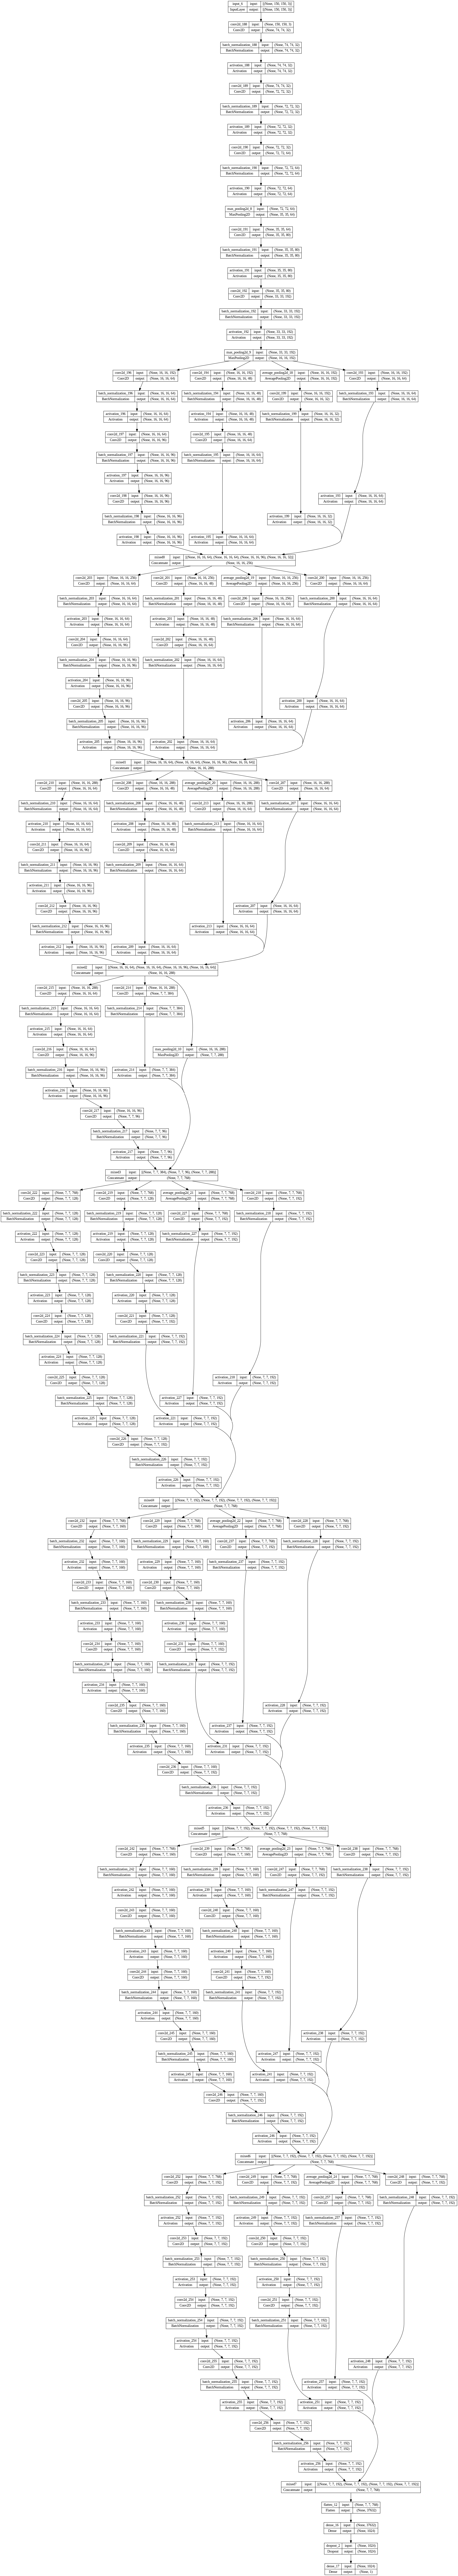

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

layer1 = tf.keras.layers.Flatten()(마지막레이어.output)
layer2 = tf.keras.layers.Dense(1024, activation='relu')(layer1)
drop1 = tf.keras.layers.Dropout(0, 2)(layer2) # overfitting 완화기능 : 윗 레이어의 노드 중 20%를 제거해주세요.
layer3 = tf.keras.layers.Dense(1, activation = 'sigmoid')(drop1)

# model = tf.keras.Model(인풋 레이어, 아웃풋 레이어)
model = tf.keras.Model(inception_model.input, layer3)

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
model.fit(train_ds, validation_data = val_ds, epochs = 5)
plot_model(model, to_file= 'model.png', show_shapes = True, show_layer_names = True )

In [34]:
# finetuning 하는 법 - 학습하고자 하는 구간의 trainable을 True로 바꿔준 뒤 
# learning_rate를 아주 작게 설정하여 weight값들이 아주 조금씩 업데이트 되도록 조정한다.

for i in inception_model.layers: # inception_model의 모든 레이어를 불러온다.
  if i.name == 'mixed6':
    i.trainable = True

# 이때 Inception 모델을 mixed6부터 조금 트레이닝 하고싶다면,

unfreeze = False
for i in inception_model.layers:
  if i.name == 'mixed6':
    unfreeze = True
  if unfreeze == True:
    i.trainable = True

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), metrics = ['acc'])
model.fit(train_ds, validation_data = val_ds, epochs = 3)

Epoch 1/3
313/313 [==============================] - 47s 120ms/step - loss: 0.0390 - acc: 0.9845 - val_loss: 0.1137 - val_acc: 0.9630
Epoch 2/3
313/313 [==============================] - 38s 119ms/step - loss: 0.0153 - acc: 0.9956 - val_loss: 0.1162 - val_acc: 0.9648
Epoch 3/3
313/313 [==============================] - 33s 104ms/step - loss: 0.0083 - acc: 0.9980 - val_loss: 0.1171 - val_acc: 0.9668


4422102/4422102 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1875/1875 [==============================] - 12s 3ms/step - loss: 0.4996 - acc: 0.8232 - val_loss: 0.4357 - val_acc: 0.8423
Epoch 2/2
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3753 - acc: 0.8654 - val_loss: 0.3929 - 

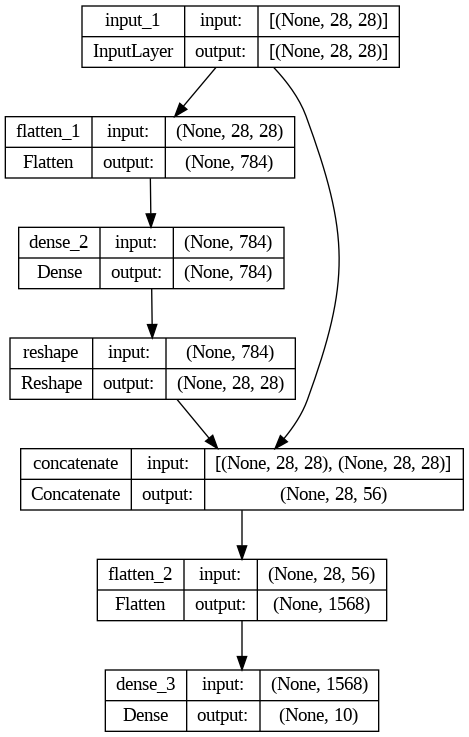

In [1]:
### Function API로 모델 만들기 연습
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


fashion_mnist = tf.keras.datasets.fashion_mnist
(trainX, trainY),(testX, testY) = tf.keras.datasets.fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankleboot']

trainX = trainX / 255.0
testX = testX / 255.0

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], 1)

model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape = ( 28, 28, 1)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax'),
])

model3.summary()
model3.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
model3.fit(trainX, trainY, validation_data = (testX, testY), epochs = 2)
plot_model(model3, to_file = 'model3.png', show_shapes = True, show_layer_names = True)

### Function API로 만들기

input1 = tf.keras.layers.Input(shape = [28, 28])
flatten1 = tf.keras.layers.Flatten()(input1)
dense1 = tf.keras.layers.Dense(28*28, activation = 'relu')(flatten1)

reshape1 = tf.keras.layers.Reshape((28, 28))(dense1)

concat1 = tf.keras.layers.Concatenate()([input1, reshape1])
flatten2 = tf.keras.layers.Flatten()(concat1)
output1 = tf.keras.layers.Dense(10, activation = 'softmax')(flatten2)

# tf.keras.Model(인 풋 레이어 변수명, 아웃 풋 레이어 변수명) 함수를 model변수에 잘 담아준다.
model4 = tf.keras.Model(input1, output1)

model4.summary()
model4.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
model4.fit(trainX, trainY, validation_data = (testX, testY), epochs = 2)
plot_model(model4, to_file = 'model4.png', show_shapes = True, show_layer_names = True)




In [3]:
import os
a = ''
for i in os.listdir('/content/'):
  for j in range (1, 8) :
    if 'model'+str(j) in i :
      os.remove(i)